<a href="https://colab.research.google.com/github/hyogyeong/ESAA/blob/main/%EC%95%84%EB%A7%88%EC%A1%B4_%EC%B6%94%EC%B2%9C%EC%8B%9C%EC%8A%A4%ED%85%9C(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install surprise

     |████████████████████████████████| 11.8 MB 51 kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619436 sha256=55154db2601e758479074901d5178d57090ce73ef5b5a04e245eaa43898dc29a
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [2]:
from google.colab import files

In [ ]:
uploaded = files.upload()

Saving ratings_Electronics (1).csv to ratings_Electronics (1).csv


In [4]:
import pandas as pd
import numpy as np

In [5]:
import torch
from fastai import * 

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
# from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

In [7]:
electronics_data = pd.read_csv("ratings_Electronics (1).csv",names=['userId', 'productId','Rating','timestamp'])

In [8]:
electronics_data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [9]:
electronics_data.shape

(1544838, 4)

In [10]:
eletronics_data = electronics_data.iloc[:1048576,0:]

In [11]:
eletronics_data.dtypes

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object

In [12]:
eletronics_data.describe()['Rating'].T

count    1.048576e+06
mean     3.973380e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [13]:
print("max of rating : %d" %(eletronics_data.Rating.max()))
print("min of rating : %d" %(eletronics_data.Rating.min()))

max of rating : 5
min of rating : 1


Missig Values 수

In [14]:
print('Number of missing values across columns: \n',electronics_data.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


Ratings

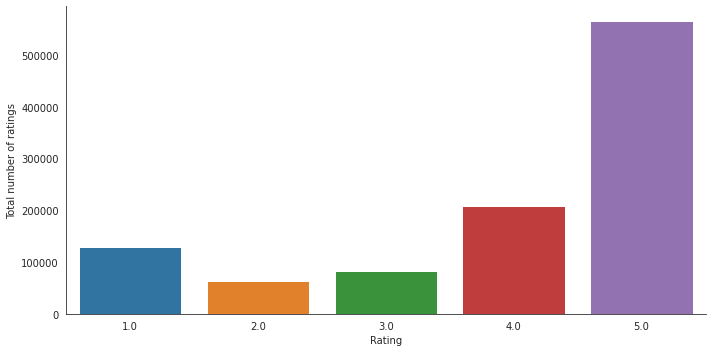

In [15]:
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data  = eletronics_data, aspect = 2.0, kind = 'count')
    g.set_ylabels("Total number of ratings")

In [16]:
print("Total data")
print("-"*50)
print("\nTotal num of ratings :", eletronics_data.shape[0])
print("Total num of Users :", len(np.unique(eletronics_data.userId)))
print("Total num of products: ", len(np.unique(eletronics_data.productId)))

Total data
--------------------------------------------------

Total num of ratings : 1048576
Total num of Users : 786330
Total num of products:  61894


In [17]:
eletronics_data.drop(['timestamp'],axis = 1, inplace = True)

Ratings 분석

In [18]:
num_of_rated_products_per_user = eletronics_data.groupby(by = 'userId')['Rating'].count().sort_values(ascending=False)
num_of_rated_products_per_user.head()

userId
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: Rating, dtype: int64

In [19]:
num_of_rated_products_per_user.describe()

count    786330.000000
mean          1.333506
std           1.385612
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         412.000000
Name: Rating, dtype: float64

거의 모든 유저들이 하나의 상품에만 평가한 것을 알 수 있다.

In [20]:
quantiles = num_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

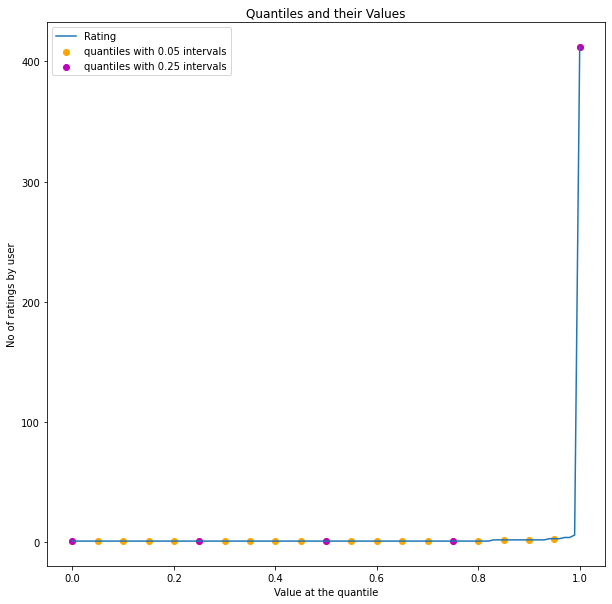

In [21]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [22]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(num_of_rated_products_per_user >= 50)) )


 No of rated product more than 50 per user : 38



50개 이상의 상품을 평가한 유저 : 38명

Popularity Based Recommendation

In [23]:
new_df=electronics_data.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

평가가 50번 이상 된 상품들을 가져옴

In [24]:
new_df.head()

,userId,productId,Rating,timestamp
183,A1BKC6B7YHYTVV,0972683275,4.0,1405382400
184,AWVFSIB42LHKJ,0972683275,4.0,1405209600
185,A36MQBNADRH8YY,0972683275,5.0,1405641600
186,A3SRXMPLAEZ6DP,0972683275,4.0,1405987200
187,A20XXTXWF2TCPY,0972683275,5.0,1405123200


In [25]:
new_df.shape

(1017324, 4)

Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[]

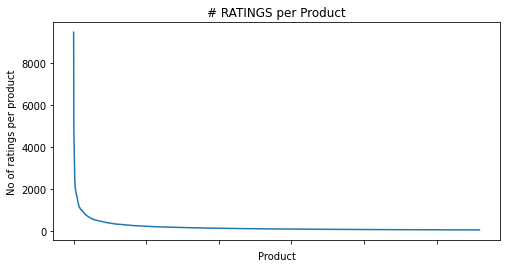

In [26]:
num_of_ratings_per_product = new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(num_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

각 상품 아이디별로 평가를 평균 내기

In [27]:
new_df.groupby('productId')['Rating'].mean().head()

productId
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: Rating, dtype: float64

sorting

In [28]:
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

productId
B000TMFYBO    4.953125
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
Name: Rating, dtype: float64

각 상품별 평가 받은 수 기준으로 내림차순 정렬

In [29]:
new_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

productId
B0002L5R78    9487
B000LRMS66    8715
B0001FTVEK    5345
B000I68BD4    4903
B000S5Q9CA    4690
Name: Rating, dtype: int64

In [30]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())

In [31]:
ratings_mean_count.head()

,Rating
productId,
0972683275,4.470980
1400501466,3.560000
1400501520,4.243902
1400501776,3.884892
1400532620,3.684211


In [32]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())

In [33]:
ratings_mean_count['rating_counts'].max()

9487

<Figure size 432x432 with 0 Axes>

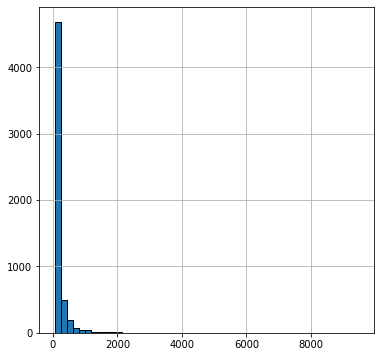

In [34]:
plt.figure(figsize=(6,6))
plt.rcParams['patch.force_edgecolor']=True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

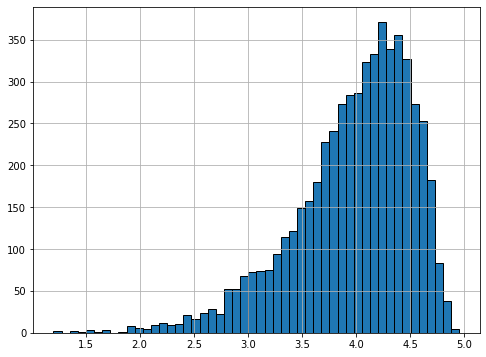

In [35]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor']=True
ratings_mean_count['Rating'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

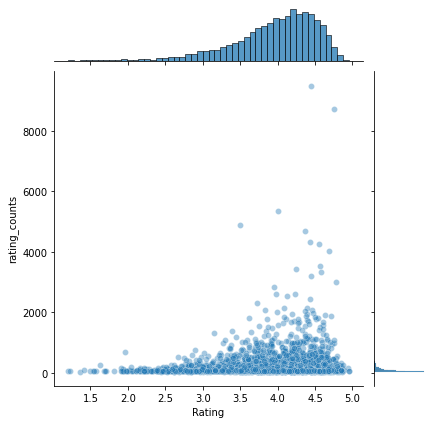

In [36]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

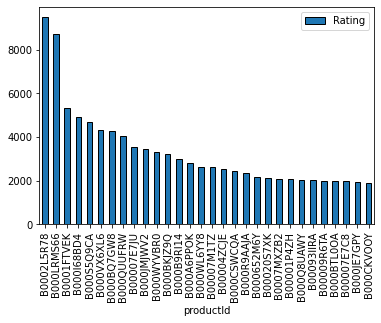

In [37]:
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values("Rating", ascending=False)
most_popular.head(30).plot(kind = "bar")

Collaborative Filtering 이용

In [38]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

1) Data 가져오기

In [39]:
new_df.drop(['timestamp'],axis = 1, inplace = True)

In [40]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(new_df,reader)

2) Trainset, Testset으로 나누기

In [41]:
trainset, testset = train_test_split(data, test_size = 0.3, random_state=10)

3) KNN을 이용 trainset에 파라미터 맞추기

In [42]:
algo = KNNWithMeans(k=5, sim_options = {'name': 'pearson_baseline', 'user_based':False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


4) Test accuracy 측정

In [43]:
test_pred = algo.test(testset)

In [44]:
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.3380


1.3379847957703965

# Model-based collaborative filtering syste

대량의 상품, 많은 사용자들에게 추천 가능, sparse한 matrices에도 사용가능

In [45]:
new_df1 = new_df.head(10000)
ratings_matrix = new_df1.pivot_table(values ='Rating', index ='userId', columns ='productId',fill_value =0)
ratings_matrix.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,3744295508,6301977173,7214047977,8862935293,9573212919,9575871979,9625993428,9888002198,9966694544,9983891212,9984984354,9985511476,B000001OM4,B000001OM5,B000001OMI,B000001ON6,B00000DM9W,B00000IGBF,B00000J05A,B00000J061,B00000J08Q,B00000J0D2,B00000J0D5,B00000J0D8,B00000J1EJ,B00000J1EP,B00000J1EQ,B00000J1F3,B00000J1GA,B00000J1QK,B00000J1QR,B00000J1SC,B00000J1TX,B00000J1U8,B00000J1UQ,B00000J1V3,B00000J1V5,B00000J3NF,B00000J3Q7,B00000J3UJ,B00000J434,B00000J4EY,B00000J4FS,B00000J4GE,B00000J6WY,B00000JBAT,B00000JBHP,B00000JBPB,B00000JCT8,B00000JCTO,B00000JD34,B00000JDF5,B00000JDF6,B00000JDHV,B00000JFE3,B00000JFIF,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A0266076X6KPZ6CCHGVS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
A0571176384K8RBNKGF8O,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
ratings_matrix.shape

(9832, 76)

In [47]:
X = ratings_matrix.T
X.head()

userId,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A0821988FXKFYX53V4QG,A099626739FNCRNHIKBCG,A1003EYWAQFOUG,A100LLXMXDZHJZ,A10121433FMMZNY18RWZ8,A1013OEQCVS6AR,A1013Q8NLCY56R,A101DJDPGK0Q46,A101IWCCIWQWC9,A10285OSAM1MZK,A102IUFPXVDRB6,A102L0RVI4LHH3,A102RLOGIBBDMW,A102ZABPUPNYCT,A1038957GWRBP375RU5T,A103XY7DJYZHFN,A104VHQ06KFLDT,A1058D8UFZL711,A105AZN9C8UAOJ,A105TOJ6LTVMBG,A106YUCY4SVX1D,A1077JEY0CE3BB,A1079KKA0AXSL3,A107I2HYD2JZ5G,A1089S59XSJT2T,A108LYH0NZ9919,A108UXJTIV8XXY,A10956KAP9F1CO,A109ZR833WIFQS,A10BH1JDT6SNGA,A10BOETDPAFJ4C,A10CRW7XRJBJ2G,...,AZKKZ58QBXZUA,AZKOO6TVQBDAF,AZL95QPWJDM3Y,AZM8PD2KBVXN5,AZMCJ61JS6L3X,AZMY6E8B52L2T,AZN6Z0QRMZYX8,AZNMO6T8G0ZEU,AZNVF1G1GJRR4,AZO3DZAJ8S0D9,AZODG8OG0CETL,AZOFJX627J181,AZOPTWUSS6UM0,AZOTUFIYPVNDT,AZPPZOYTNLEN0,AZPT44204EODM,AZPT6K5K0IVCT,AZPYIAOEAV3OZ,AZQ2YSCWSKWX6,AZQ9DYG38GVBR,AZQJQBJ75DHMS,AZQOWHUHXMIMS,AZQQVI9RHJYH6,AZQTJ6HUS5L2Q,AZRPGTU8A7KD5,AZS8W54PXQ01W,AZSUNAT0BRQDU,AZTC7YC8PKG39,AZTC8ZV20NO1D,AZV9WA9MNT0FB,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXKUK895VGSM,AZXP46IB63PU8,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZST8OYL5P4Q
productId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0972683275,0,0,5,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,5,0,4,0,0,0,5,0,0,0,0,0,...,0,0,0,5,0,0,0,0,0,5,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1400501520,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1400501776,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1400532620,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [48]:
X.shape

(76, 9832)

In [49]:
X.index

Index(['0972683275', '1400501466', '1400501520', '1400501776', '1400532620',
       '1400532655', '140053271X', '1400532736', '1400599997', '1400698987',
       '3744295508', '6301977173', '7214047977', '8862935293', '9573212919',
       '9575871979', '9625993428', '9888002198', '9966694544', '9983891212',
       '9984984354', '9985511476', 'B000001OM4', 'B000001OM5', 'B000001OMI',
       'B000001ON6', 'B00000DM9W', 'B00000IGBF', 'B00000J05A', 'B00000J061',
       'B00000J08Q', 'B00000J0D2', 'B00000J0D5', 'B00000J0D8', 'B00000J1EJ',
       'B00000J1EP', 'B00000J1EQ', 'B00000J1F3', 'B00000J1GA', 'B00000J1QK',
       'B00000J1QR', 'B00000J1SC', 'B00000J1TX', 'B00000J1U8', 'B00000J1UQ',
       'B00000J1V3', 'B00000J1V5', 'B00000J3NF', 'B00000J3Q7', 'B00000J3UJ',
       'B00000J434', 'B00000J4EY', 'B00000J4FS', 'B00000J4GE', 'B00000J6WY',
       'B00000JBAT', 'B00000JBHP', 'B00000JBPB', 'B00000JCT8', 'B00000JCTO',
       'B00000JD34', 'B00000JDF5', 'B00000JDF6', 'B00000JDHV', 'B00000JFE3',

In [50]:
X1 = X

In [51]:
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(76, 10)

In [52]:
decomposed_matrix

array([[ 1.48104508e+02, -1.54620254e-01,  2.45986058e-02,
        -7.45802791e-05, -1.34214603e-01,  3.16992039e-05,
         4.59292817e-02, -2.97365885e-04, -2.46314434e-03,
        -8.38276340e-02],
       [ 5.84450964e-04,  1.29442397e+00,  1.45093990e+00,
         1.67110951e-01, -1.13047408e-04, -1.75866128e-02,
        -4.46620614e-02,  1.84723870e-01,  6.08454129e+01,
        -1.88855154e+00],
       [ 4.14992751e-05,  9.57781254e-02,  3.19873906e-01,
         1.08323658e-02, -2.49215670e-03,  2.24973597e-03,
        -1.96170180e-03, -4.73585281e-02,  1.58898858e+00,
        -2.38189279e-01],
       [ 5.50046527e-04,  7.54461141e-01,  5.08610831e-01,
         5.18100990e-04,  2.78215634e-02,  4.85342388e-02,
         7.63372441e-02, -3.16174848e-02,  4.92138891e+00,
        -3.07209223e-01],
       [ 5.89884705e-04,  7.87884645e-01,  1.10953184e+00,
         4.06240309e-02, -1.01610542e-02, -1.75837110e-02,
        -1.61268258e-04, -1.65201181e-01,  1.26312033e+00,
        -4.

In [53]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(76, 76)

In [54]:
X.index[75]

'B00000K135'

In [55]:
i = X.index[75]

product_names = list(X.index)
product_ID = product_names.index(i) #index구하기
product_ID

75

In [56]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(76,)

In [57]:
correlation_product_ID

array([ 0.08826308, -0.99304344, -0.98051131, -0.98656634, -0.66597395,
        0.07764077,  0.11107488, -0.80715972, -0.73701704, -0.97655684,
        0.95295993, -0.97041274, -0.98570565, -0.98733611,  0.75277187,
       -0.29929013,  0.9431229 ,  0.96974358, -0.92361678,  0.20066607,
        0.06857646,  0.9582325 , -0.97894149, -0.15255128,  0.15322247,
        0.97917344,  0.09358954, -0.93119866, -0.97229409,  0.16280701,
       -0.99602018, -0.9602798 ,  0.79368622,  0.85856976,  0.96597762,
        0.96011789,  0.94719493,  0.97647541,  0.03498369, -0.91229093,
       -0.33360844,  0.98623283,  0.99250685, -0.99188455, -0.99492845,
       -0.07572559,  0.04428681, -0.95361439, -0.31149108,  0.7450391 ,
       -0.96256374,  0.95967387, -0.97799394, -0.69295442,  0.95504086,
       -0.60116464, -0.3183001 ,  0.13483504, -0.15317906,  0.61267543,
        0.98245688,  0.09110023,  0.01682001, -0.87837668,  0.14641846,
        0.99867417, -0.74600022, -0.92533506,  0.11107997, -0.99

In [58]:
Recommend = list(X.index[correlation_product_ID > 0.65]) #피어슨 상관계수가 0.65보다 큰 상품들의 index의 list return

Recommend.remove(i) # 이미 구입한 상품은 뺀다

Recommend[0:24] #상위 24개 추천

['3744295508',
 '9573212919',
 '9625993428',
 '9888002198',
 '9985511476',
 'B000001ON6',
 'B00000J0D5',
 'B00000J0D8',
 'B00000J1EJ',
 'B00000J1EP',
 'B00000J1EQ',
 'B00000J1F3',
 'B00000J1SC',
 'B00000J1TX',
 'B00000J3UJ',
 'B00000J4EY',
 'B00000J6WY',
 'B00000JD34',
 'B00000JFIF',
 'B00000JMUG',
 'B00000JPPI',
 'B00000JYWQ']

In [59]:
Recommend

['3744295508',
 '9573212919',
 '9625993428',
 '9888002198',
 '9985511476',
 'B000001ON6',
 'B00000J0D5',
 'B00000J0D8',
 'B00000J1EJ',
 'B00000J1EP',
 'B00000J1EQ',
 'B00000J1F3',
 'B00000J1SC',
 'B00000J1TX',
 'B00000J3UJ',
 'B00000J4EY',
 'B00000J6WY',
 'B00000JD34',
 'B00000JFIF',
 'B00000JMUG',
 'B00000JPPI',
 'B00000JYWQ']